In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob


In [50]:
# initial parameters
epochs = 150
lr = 1e-3
batch_size = 32
img_dims = (96,96,3)

data = []
labels = []

# load image files from the dataset
image_files = [f for f in glob.glob(r'Gender-Detection/gender_dataset_face' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)


In [51]:
# converting images to arrays and labelling the categories
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
        
    data.append(image)

    label = img.split(os.path.sep)[-2] # C:\Files\gender_dataset_face\woman\face_1162.jpg
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label]) # [[1], [0], [0], ...]


In [52]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.15,
                                                  random_state=42)

trainY = to_categorical(trainY, num_classes=2) # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)


In [53]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")


In [54]:
# define model
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # Personnal adds

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))


    
    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model


In [55]:
# build model
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)

# compile the model
opt = Adam(learning_rate=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


In [56]:
# train the model
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)


Epoch 1/150


2022-04-13 21:51:23.419523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/61 [============================>.] - ETA: 0s - loss: 0.9553 - accuracy: 0.6477

2022-04-13 21:51:26.262031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 [==============================] - 4s 43ms/step - loss: 0.9540 - accuracy: 0.6463 - val_loss: 0.6914 - val_accuracy: 0.5187
Epoch 2/150
61/61 [==============================] - 2s 32ms/step - loss: 0.5606 - accuracy: 0.7682 - val_loss: 0.6705 - val_accuracy: 0.5331
Epoch 3/150
61/61 [==============================] - 2s 30ms/step - loss: 0.5320 - accuracy: 0.7733 - val_loss: 0.7129 - val_accuracy: 0.5216
Epoch 4/150
61/61 [==============================] - 2s 29ms/step - loss: 0.4604 - accuracy: 0.7993 - val_loss: 0.7804 - val_accuracy: 0.4928
Epoch 5/150
61/61 [==============================] - 2s 30ms/step - loss: 0.3755 - accuracy: 0.8418 - val_loss: 1.0409 - val_accuracy: 0.4870
Epoch 6/150
61/61 [==============================] - 2s 30ms/step - loss: 0.3452 - accuracy: 0.8703 - val_loss: 0.5708 - val_accuracy: 0.6715
Epoch 7/150
61/61 [==============================] - 2s 29ms/step - loss: 0.3115 - accuracy: 0.8750 - val_loss: 0.9586 - val_accuracy: 0.6081
Epoch 8/150
61/61 

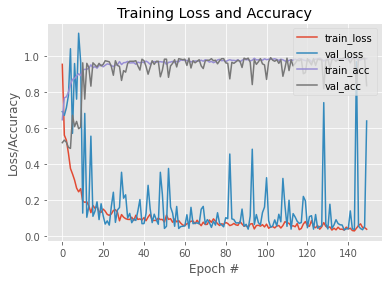

In [57]:
# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# save plot to disk
#plt.savefig('plot.png')

In [58]:
model.evaluate(testX, testY, verbose=1)

11/11 [==============================] - 0s 9ms/step - loss: 0.6394 - accuracy: 0.8357


[0.6393630504608154, 0.8357349038124084]

In [59]:
from tensorflow.keras import layers

In [133]:

# define model
def build2(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(256, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

In [134]:
epochs2 = 130

In [135]:
# build model
model2 = build2(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)

# compile the model
opt = Adam(learning_rate=lr, decay=lr/epochs2)
model2.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

H2 = model2.fit(aug.flow(trainX, trainY, batch_size
=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs2, verbose=1)

Epoch 1/130


2022-04-13 22:53:32.839203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/61 [============================>.] - ETA: 0s - loss: 1.2007 - accuracy: 0.5923

2022-04-13 22:53:36.603784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 [==============================] - 5s 54ms/step - loss: 1.2000 - accuracy: 0.5902 - val_loss: 0.7096 - val_accuracy: 0.5187
Epoch 2/130
61/61 [==============================] - 2s 35ms/step - loss: 0.6949 - accuracy: 0.7132 - val_loss: 0.6618 - val_accuracy: 0.5793
Epoch 3/130
61/61 [==============================] - 2s 35ms/step - loss: 0.5259 - accuracy: 0.7723 - val_loss: 0.7275 - val_accuracy: 0.4928
Epoch 4/130
61/61 [==============================] - 2s 34ms/step - loss: 0.4304 - accuracy: 0.8164 - val_loss: 0.7107 - val_accuracy: 0.5072
Epoch 5/130
61/61 [==============================] - 2s 37ms/step - loss: 0.3667 - accuracy: 0.8470 - val_loss: 0.7860 - val_accuracy: 0.5159
Epoch 6/130
61/61 [==============================] - 2s 34ms/step - loss: 0.2991 - accuracy: 0.8781 - val_loss: 0.3963 - val_accuracy: 0.8444
Epoch 7/130
61/61 [==============================] - 2s 34ms/step - loss: 0.2721 - accuracy: 0.8869 - val_loss: 0.6042 - val_accuracy: 0.7378
Epoch 8/130
61/61 

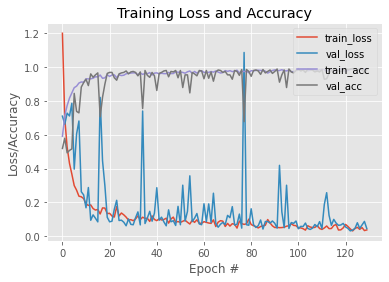

In [136]:
# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs2
plt.plot(np.arange(0,N), H2.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H2.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H2.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H2.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

In [ ]:
import pickle

pickle.dump(model, open('model.pkl', 'wb'))

2022-04-13 19:29:54.681885: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://542e8bb9-0298-425f-b829-4362b47c726f/assets
